This notebook takes functions and code from the ImageAnalysisDevelopment notebook and uses them to create figures for the BMES conference. 

There are also some minor changes to handle an extra time dimension in the stacks from the microscope

In [1]:
import sys
import time

import gspread
from oauth2client.service_account import ServiceAccountCredentials

import numpy as np
import pandas as pd
from nd2reader import ND2Reader 
from scipy import ndimage as ndi
import pims
from PIL import Image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

from ipywidgets import interact
import ipywidgets as ipw
mpl.rcParams['figure.figsize'] = (25,64)

# mpl.rcParams['figure.figsize'] = [15.0, 10.0]



### Load images to be used for testing image analysis

In [2]:
imageDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/20181005/'
expID = 'SSN_095_001'

In [3]:
def loadImages(imageDir,expID):
    images = pims.open(imageDir+expID+'.nd2')
    images.bundle_axes = ['z', 'y', 'x']
#     meta = images.metadata
#     print(meta)
#     numSlices = meta['total_images_per_channel']
    
    imageArray = np.asarray(images)
    imageArray = imageArray.squeeze()
    # print(imageArray.shape)
    return imageArray

def getMetadata(imageDir,experimentID):
    warnings.filterwarnings("ignore", message="RuntimeWarning: Reported average frame interval")

    
    # Access google drive spreadsheet
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('SenseOfTouchResearch-e5927f56c4d0.json', scope)
    c = gspread.authorize(credentials)
    metadataSpread = c.open_by_key('1LsTdPBOW79XSkk5DJv2ckiVTvpofAOOd_dJL4cgtxBQ')
    metadataFrame = pd.DataFrame(metadataSpread.sheet1.get_all_records())
    gdriveMetadata = metadataFrame.loc[metadataFrame['Experiment ID'] == 'SSN_089_001']
    
    # Access the metadata embedded in the file from the microscope
    images = pims.open(imageDir+expID+'.nd2')
    meta = images.metadata
    print(meta)
    keysToKeep = ['height','width','date','total_images_per_channel','channels','pixel_microns','num_frames']
    metadataFromScope = { keyToKeep: meta[keyToKeep] for keyToKeep in keysToKeep }
    metadataFromScope = pd.DataFrame(metadataFromScope)
    
    imagesPerStack = {'numZSlices': metadataFromScope.total_images_per_channel / metadataFromScope.num_frames}
    derivedMetadata = pd.DataFrame(imagesPerStack)
    
    gdriveMetadata=gdriveMetadata.reset_index(drop=True)
    metadataFromScope=metadataFromScope.reset_index(drop=True)
    currentMetadata = metadataFromScope.join(gdriveMetadata)
    
    currentMetadata = pd.concat([currentMetadata,derivedMetadata],axis=1)

    return currentMetadata
    
    
    
imageArray = loadImages(imageDir,expID)
thisMetadata = getMetadata(imageDir,expID)


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (29917.7 ms) doesn't match the set interval (1000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


{'height': 512, 'width': 200, 'date': datetime.datetime(2018, 10, 5, 9, 1, 44), 'fields_of_view': [0], 'frames': [0, 1, 2, 3, 4], 'z_levels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187], 'total_images_per_channel'

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (29917.7 ms) doesn't match the set interval (1000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [4]:
thisMetadata

,height,width,date,total_images_per_channel,channels,pixel_microns,num_frames,Bleach Date,Bleach Time,Cultivation Temperature (°C),...,Neuron,Notes,Number of eggs visible,Objective,Purpose of Experiment,Timestamp,Worm Strain,Worm head orientation,Worm vulva orientation,numZSlices
0,512,200,2018-10-05 09:01:44,940,SDC 561-ALN,0.354202,5,9/24/2018,3:15:00 PM,20,...,PVM,"Some autofluorescence, but can see TRNs.",0,40x oil,Baseline measurement,9/27/2018 14:00:11,NM3573,Headfirst,West,188.0


### Functions for plotting

In [5]:
imageArray[0].shape

(188, 512, 200)

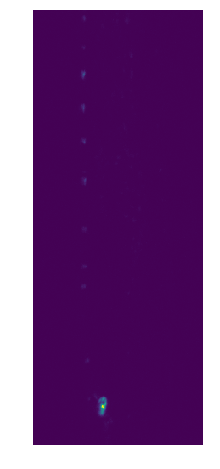

In [6]:
def dispMaxProjection(images,axis='z'):
    ## Parse axis input
    if axis == 'z':
        axIndex = 0
    elif axis == 'y':
        axIndex = 1
    elif axis == 'x':
        axIndex = 2

    
    
    # convert data to numpy array
    maxProjection = np.amax(images,axIndex) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    
    # print a bit of info for the user
    vulvaSide = thisMetadata.loc[0,'Worm vulva orientation']
    #print('Worm vulva is on the '+vulvaSide+ ' side.')
    
    # figure axis setup  with increased figure size
    maxProjFig = plt.figure(figsize = (8,8)) 
    ax = maxProjFig.add_subplot(111)

    # display  image 
    ax.imshow(maxProjection, interpolation='none')
    ax.set_axis_off()
    #ax.set_title('Max projection along z')
#     plt.show()

    return maxProjFig
    
testFig = dispMaxProjection(imageArray[2]) 
testFig.show()
# testFig.savefig('/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/RawMaxProjection.png',bbox_inches='tight')

In [7]:
def saveMaxProj(zStack,filename):
    rawMaxProj = np.amax(zStack,0) # collapse z axis
    rawMaxProj = rawMaxProj.squeeze()
    rawMaxProj = np.asarray(rawMaxProj)
    maxProjImage = Image.fromarray(rawMaxProj)
    maxProjImage = maxProjImage.convert('I')

    # if maxProjImage.mode != 'RGB':
    #     maxProjImage = maxProjImage.convert('RGB')
    maxProjImage.save(filename,transparent=True,frameon=False,bbox_inches='tight',pad_inches=0)

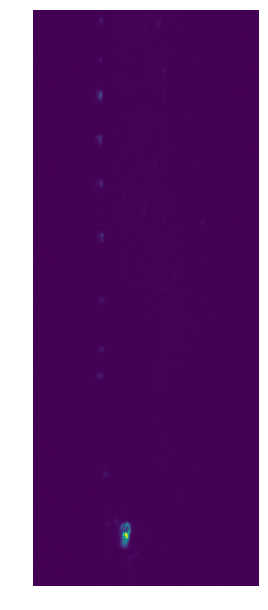

In [8]:
rawMaxProjFilename = '/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/RawMaxProjection.png'
# saveMaxProj(imageArray[2,20:],rawMaxProjFilename)
rawMaxProjFig = dispMaxProjection(imageArray[2,20:])
rawMaxProjFig.subplots_adjust(bottom = 0)
rawMaxProjFig.subplots_adjust(top = 1)
rawMaxProjFig.subplots_adjust(right = 1)
rawMaxProjFig.subplots_adjust(left = 0)
rawMaxProjFig.savefig(rawMaxProjFilename,transparent=True,frameon=False,bbox_inches='tight',pad_inches=0)

Worm vulva is on the West side.


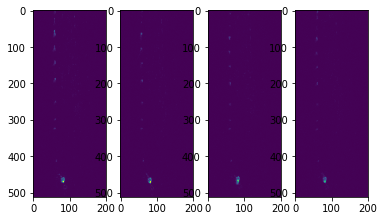

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

In [9]:
def dispAllMaxProjection(images):
    f, axarr = plt.subplots(1,images.shape[0])
    
    for i in range(images.shape[0]):
        # convert data to numpy array
        maxProjection = np.amax(images[i],0) # collapse z axis
        maxProjection = maxProjection.squeeze()
        maxProjection = np.asarray(maxProjection)
    
    
    
        # figure axis setup  with increased figure size
        f = plt.figure(figsize = (50,5)) 
#         mpl.rcParams['figure.figsize'] = (16,8)
#         ax = maxProjFig.add_subplot(111)

        # display  image 
        axarr[i].imshow(maxProjection)
        #ax.imshow(maxProjection, interpolation='none')
        #axarr.set_title('Stack number '+ str(i))
#     plt.show()

    # print a bit of info for the user
    vulvaSide = thisMetadata.loc[0,'Worm vulva orientation']
    print('Worm vulva is on the '+vulvaSide+ ' side.')

    return f

#mpl.rcParams['figure.figsize'] = (16,8)

testFig = dispAllMaxProjection(imageArray[0:4])
testFig.show()


In [10]:
def plotCurrentSlice(currentSlice,stack):
    # figure axis setup  with increased figure size
    imFig, ax = plt.subplots(figsize=(8,8))

    # display initial image 
    thisIm = ax.imshow(stack[currentSlice], interpolation='none')
    
    return 
def scrollingFig(currentStack):
    interact(plotCurrentSlice,currentSlice = ipw.IntSlider(min=0,max=currentStack.shape[0]-1,step=1,value=0),stack = ipw.fixed(currentStack))

In [11]:
scrollingFig(imageArray[2])

interactive(children=(IntSlider(value=0, description='currentSlice', max=187), Output()), _dom_classes=('widge…

# Preprocessing 

### Choose which slices to analyze

In [12]:
# Manual choice
slicesToAnalyze = imageArray[2,60:110]

Manually choosing slices is probably not sustainable.

# Gaussian filter

In [13]:
# Gaussian filter
gaussFiltSubStack = ndi.filters.gaussian_filter(slicesToAnalyze,2)
scrollingFig(gaussFiltSubStack)

interactive(children=(IntSlider(value=0, description='currentSlice', max=49), Output()), _dom_classes=('widget…

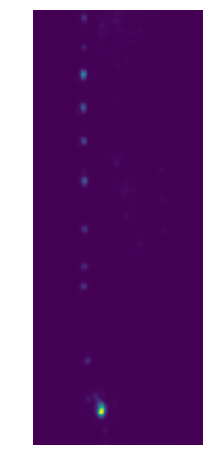

In [14]:
gaussFiltMaxProjFilename = '/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/GaussFiltProjection.png'
# saveMaxProj(gaussFiltSubStack,gaussFiltMaxProjFilename)

gaussFiltFig = dispMaxProjection(gaussFiltSubStack)
gaussFiltFig.savefig(gaussFiltMaxProjFilename,transparent=True,frameon=False,bbox_inches='tight',pad_inches=0)

# Median filter

In [15]:
medianFiltSubStack = ndi.filters.median_filter(slicesToAnalyze,3)
scrollingFig(medianFiltSubStack)

interactive(children=(IntSlider(value=0, description='currentSlice', max=49), Output()), _dom_classes=('widget…

The median filter doesn't blur the mitochondria as much, but the contrast doesn't look as high.

# Segmentation

In [16]:
gaussFiltSubStack.shape

(50, 512, 200)

In [17]:
# 3D particle tracking (trackpy)
# tutorial here: http://soft-matter.github.io/trackpy/v0.4.1/tutorial/tracking-3d.html
import trackpy as tp
warnings.filterwarnings("ignore", message="Using a non-tuple sequence for multidimensional indexing is deprecated")


mitoCandidates = tp.locate(gaussFiltSubStack,diameter=(25,15,15),percentile=50) # does this perform gaussian blurring?
# tp.annotate3d(mitoCandidates,gaussFiltSubStack)

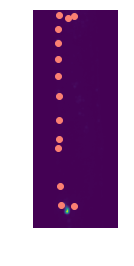

In [18]:
maxProjection = np.amax(gaussFiltSubStack,0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)

# figure axis setup  with increased figure size
mitoLabelFig, ax= plt.subplots() 
ax.imshow(maxProjection)
mitoCandidates.plot(x='x', y='y', ax = ax, color = '#FB8072', marker='o', linestyle='None')
ax.legend_.remove()
plt.axis('off')

mitoLabelFilename = '/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/MitoLabelFig.png'
mitoLabelFig.savefig(mitoLabelFilename,transparent=True,frameon=False,bbox_inches='tight',pad_inches=0)

Tried several different percentile settings for trackpy locate function. Even a percentile of 80 results in a lot of off-target points sometimes. High 90s seem to be the best setting for some stacks, but not others. Not sure how to optimize this.

In [19]:
mitoPositionsFilename = '/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/MitoPositions.csv'

mitoCoords = mitoCandidates[['y','x']]
mitoCoords = mitoCoords.values
mitoCoords = mitoCoords.transpose()
np.savetxt(mitoPositionsFilename, mitoCoords, delimiter=",")

In [20]:
# mitoCandidates = tp.locate(imageArray[0,20:],diameter=(9,9,9),percentile=50) # does this perform gaussian blurring?
# tp.annotate3d(mitoCandidates,imageArray[0,20:])

In [21]:
# maxProjection = np.amax(imageArray[0,20:],0) # collapse z axis
# maxProjection = maxProjection.squeeze()
# maxProjection = np.asarray(maxProjection)

# tp.annotate(mitoCandidates,maxProjection)

# myFig = dispMaxProjection(imageArray[0,20:])

### Now iterate through all 5 of the first set of stacks

In [22]:
frames = np.ndarray(imageArray[1:5,20:].shape)
for i in range(frames.shape[0]):
    gaussFiltSubStack = ndi.filters.gaussian_filter(imageArray[i,20:],2)
    frames[i] = gaussFiltSubStack#np.concatenate((frames,gaussFiltSubStack),axis=0)

start = time.time()
f = tp.batch(frames, diameter=(25,15,15),percentile=50)
linked = tp.link_df(f, 20, pos_columns=['x', 'y', 'z'])
done = time.time()
print('time elapsed:',done-start)
FilteredTrajectories = tp.filter_stubs(linked,4)
numParticles = FilteredTrajectories.groupby('particle').nunique().shape[0]


Frame 3: 58 trajectories present.
time elapsed: 209.67703700065613


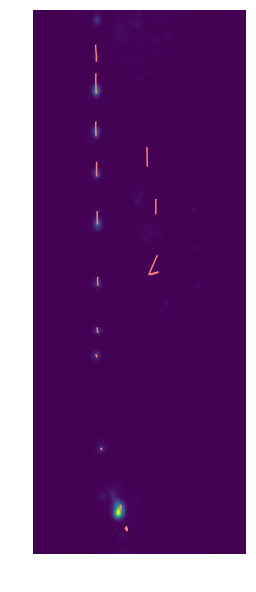

In [23]:
# figure axis setup  with increased figure size
mpl.rcParams['figure.figsize'] = (25,64)

TrajectoryFig, ax2= plt.subplots() 
ax2.imshow(maxProjection)

for i in range(max(FilteredTrajectories['particle'])):
    thisParticleTraj = FilteredTrajectories.loc[FilteredTrajectories['particle']==i+1]
    if not thisParticleTraj.empty:
        thisParticleTraj.plot(x='x', y='y', ax = ax2, color = '#FB8072',figsize=(20,10))
#     else:
#         print('No data for particle '+str(i)+'.')

ax2.set_axis_off()
ax2.legend_.remove()


trajFigFilename = '/Users/adam/Documents/SenseOfTouchResearch/Posters/BMES2018/TrajectoryFig.png'
TrajectoryFig.savefig(trajFigFilename,transparent=True,frameon=False,bbox_inches='tight',pad_inches=0)



Worm vulva is on the West side.


<Figure size 3600x360 with 0 Axes>

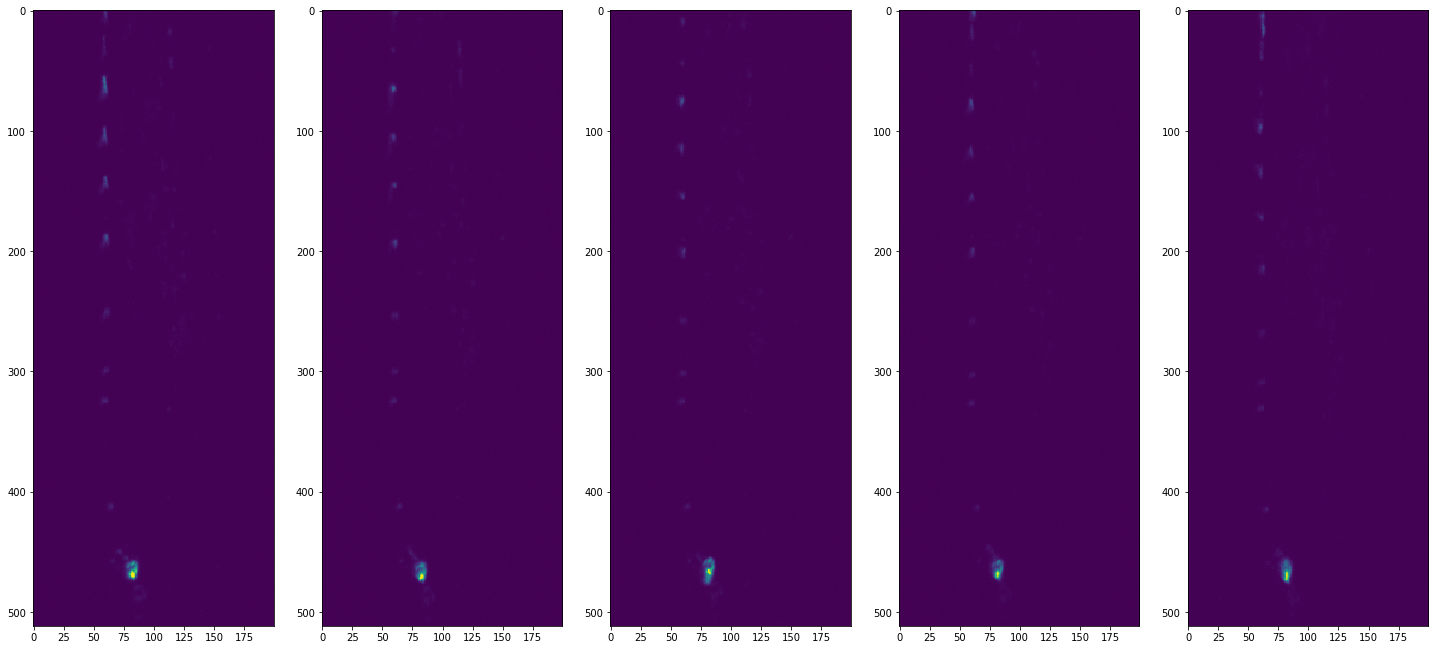

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

<Figure size 3600x360 with 0 Axes>

In [24]:
dispAllMaxProjection(imageArray[:,20:])



In [25]:
distances = tp.static.proximity(FilteredTrajectories)
strain = np.ndarray((numParticles,frames.shape[0]))
for particle in range(numParticles):
    thisParticle = distances.loc[[particle+1]]
#     print(thisParticle)
    distInitial = thisParticle.iloc[0]['proximity'] 
    for frame in range(thisParticleTraj.shape[0]):
        distCurrent = thisParticle.iloc[frame]['proximity']
        strain[particle,frame] = (distCurrent - distInitial) / distInitial


# strainFig, ax3= plt.subplots() 
# for i in range(distances.shape[0]):
#     plt.plot()


KeyError: 'None of [[7]] are in the [index]'

In [ ]:
FilteredTrajectories.groupby('particle').nunique().shape[0]


In [ ]:
range(max(FilteredTrajectories['particle']))

In [ ]:
frames.shape[0]

In [ ]:
numParticles